In [2]:
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Load data
df = pd.read_csv("modeling_dataframe.csv")  # or however you load it
y_col = "success_outcome"
X_cols = [c for c in df.columns if c != y_col]
X_all, y_all = df[X_cols], df[y_col]

# Load params
with open("rf_best_params.json") as f:
    rf_params = json.load(f)
with open("gb_best_params.json") as f:
    gb_params = json.load(f)

# Recreate tuned models
best_rf = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(**rf_params, n_jobs=-1, random_state=42)
)
best_gb = HistGradientBoostingRegressor(**gb_params, random_state=42)

# Fit on full data
best_rf.fit(X_all, y_all)
best_gb.fit(X_all, y_all)

print("Models reloaded and refit. Ready for SHAP or evaluation.")

Models reloaded and refit. Ready for SHAP or evaluation.


100%|===================| 55448/55454 [145:11<00:00]        


[RF] Top 20 by mean |SHAP|:
 yards_after_catch_missing             0.126316
air_yards_for_model                   0.069453
yards_after_catch                     0.056273
drive_play_index                      0.048387
defense_coverage_type_COVER_0         0.010586
route_GO                              0.008785
route_CORNER                          0.004897
pass_rate_so_far                      0.004816
defenders_in_box                      0.003866
defense_man_zone_type_MAN_COVERAGE    0.003003
time_to_throw                         0.002933
completion_rate_so_far                0.002195
route_POST                            0.002151
defense_coverage_type_COVER_1         0.001763
score_differential                    0.001713
route_SCREEN                          0.001474
tod_unix                              0.001424
first_down_rush_so_far                0.001315
rush_attempt_so_far                   0.001020
first_down_penalty_so_far             0.000973
dtype: float64


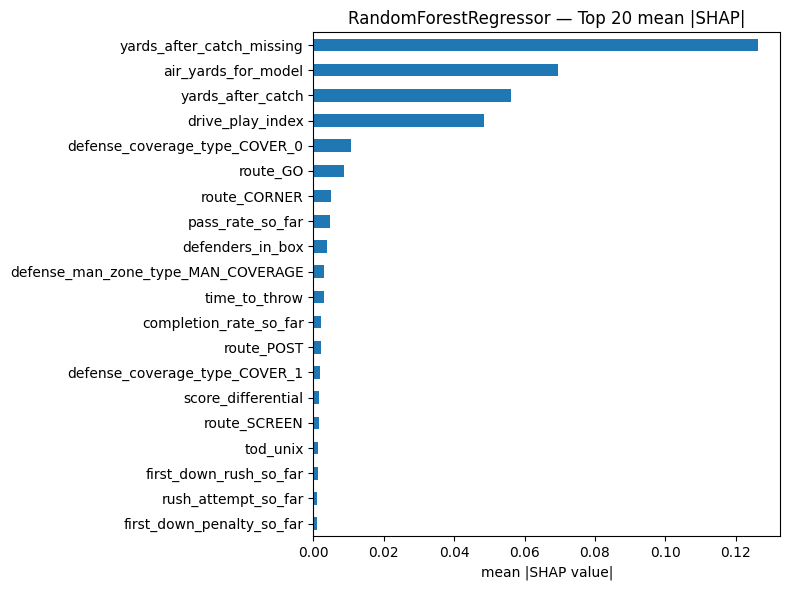

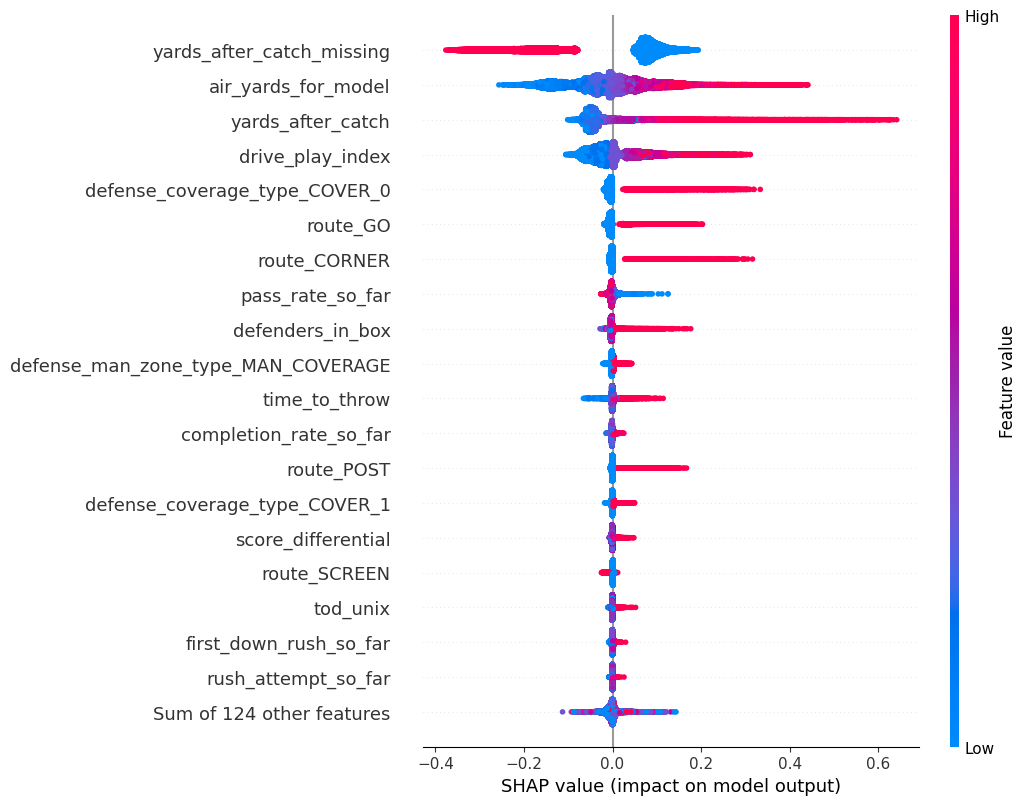

100%|===================| 55423/55454 [11:45<00:00]        

[HistGB] Generic Explainer failed (Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.674475, while the model output was 0.739095. If this difference is acceptable you can set check_additivity=False to disable this check.). Trying TreeExplainer...


100%|===================| 55441/55454 [72:54<00:01]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.674475, while the model output was 0.739095. If this difference is acceptable you can set check_additivity=False to disable this check.

In [6]:
# ===== SHAP (version-robust) for RF (pipeline) and HistGB =====
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from packaging.version import parse as vparse
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Feature names
feature_names = X_all.columns.tolist()

# ---- Get steps safely from your RF pipeline ----
rf_imputer = None
rf_model = None
for name, step in best_rf.named_steps.items():
    if isinstance(step, SimpleImputer):
        rf_imputer = step
    if isinstance(step, RandomForestRegressor):
        rf_model = step
assert rf_imputer is not None and rf_model is not None, "Could not find SimpleImputer/RF in best_rf pipeline."

# Transform X for RF (imputed)
X_rf = rf_imputer.transform(X_all).astype(float)

# Background datasets (keep small but representative)
def make_background(X_np, max_k=256, seed=42):
    n = X_np.shape[0]
    if n <= max_k:
        return X_np  # small: use all rows
    rng = np.random.RandomState(seed)
    idx = rng.choice(n, size=max_k, replace=False)
    return X_np[idx]

rf_background = make_background(X_rf, max_k=256)
gb_background_df = X_all.sample(n=min(1000, len(X_all)), random_state=42)  # HGB can take a pandas df

# ========== RandomForestRegressor ==========
try:
    # Preferred (new SHAP): explicit masker + generic Explainer
    masker_rf = shap.maskers.Independent(rf_background)
    rf_explainer = shap.Explainer(rf_model, masker_rf)   # auto-selects TreeExplainer under the hood
    rf_shap_exp = rf_explainer(X_rf)                     # returns shap.Explanation
    rf_values = rf_shap_exp.values
except Exception as e:
    print(f"[RF] New-style masker path failed ({e}). Falling back to legacy TreeExplainer...")
    # Fallback (legacy): TreeExplainer with interventional perturbation and additivity off if needed
    rf_explainer = shap.TreeExplainer(
        rf_model,
        feature_perturbation="interventional"
    )
    # Some versions need check_additivity=False to avoid warnings/errors
    rf_shap_exp = rf_explainer(X_rf, check_additivity=False)
    rf_values = rf_shap_exp.values if hasattr(rf_shap_exp, "values") else rf_shap_exp

# Global importance
rf_importance = np.abs(rf_values).mean(axis=0)
rf_importance_s = pd.Series(rf_importance, index=feature_names).sort_values(ascending=False)
print("\n[RF] Top 20 by mean |SHAP|:\n", rf_importance_s.head(20))

# Plot
plt.figure(figsize=(8,6))
rf_importance_s.head(20)[::-1].plot(kind='barh')
plt.title("RandomForestRegressor — Top 20 mean |SHAP|")
plt.xlabel("mean |SHAP value|")
plt.tight_layout()
plt.show()

# Beeswarm (optional)
try:
    shap.plots.beeswarm(
        shap.Explanation(values=rf_values,
                         base_values=getattr(rf_shap_exp, "base_values", None),
                         data=X_rf,
                         feature_names=feature_names),
        max_display=20, show=True
    )
except Exception as e:
    print(f"[RF] Beeswarm skipped: {e}")

# ========== HistGradientBoostingRegressor ==========
try:
    # Generic Explainer handles tree models and builds a proper masker automatically
    gb_explainer = shap.Explainer(best_gb, gb_background_df)
    gb_shap_exp = gb_explainer(X_all)
    gb_values = gb_shap_exp.values
    gb_data = gb_shap_exp.data if hasattr(gb_shap_exp, "data") else X_all.values
except Exception as e:
    print(f"[HistGB] Generic Explainer failed ({e}). Trying TreeExplainer...")
    # Robust fallback
    masker_gb = shap.maskers.Independent(gb_background_df)
    gb_explainer = shap.Explainer(best_gb, masker_gb)
    gb_shap_exp = gb_explainer(X_all)
    gb_values = gb_shap_exp.values
    gb_data = gb_shap_exp.data if hasattr(gb_shap_exp, "data") else X_all.values

gb_importance = np.abs(gb_values).mean(axis=0)
gb_importance_s = pd.Series(gb_importance, index=feature_names).sort_values(ascending=False)
print("\n[HistGB] Top 20 by mean |SHAP|:\n", gb_importance_s.head(20))

plt.figure(figsize=(8,6))
gb_importance_s.head(20)[::-1].plot(kind='barh')
plt.title("HistGradientBoostingRegressor — Top 20 mean |SHAP|")
plt.xlabel("mean |SHAP value|")
plt.tight_layout()
plt.show()

try:
    shap.plots.beeswarm(
        shap.Explanation(values=gb_values,
                         base_values=getattr(gb_shap_exp, "base_values", None),
                         data=gb_data,
                         feature_names=feature_names),
        max_display=20, show=True
    )
except Exception as e:
    print(f"[HistGB] Beeswarm skipped: {e}")

# Save importances
rf_importance_s.to_csv("rf_shap_importance.csv")
gb_importance_s.to_csv("histgb_shap_importance.csv")
print("Saved: rf_shap_importance.csv, histgb_shap_importance.csv")